In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import numpy as np
import pandas as pd
import modules
import matplotlib.pyplot as plt

from sklearn.metrics import *
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

np.random.seed(0)
torch.manual_seed(0)

In [3]:
def compute_auc_mcc(pred_paths, threshold):
    overall_pred = list()
    overall_true = list()
    overall_thres_pred = list()
    individual_auc = list()
    individual_mcc = list()

    for i in range(len(pred_paths)):
        data = torch.load(pred_paths[i])
        pred = data["y_pred"]
        true = data["y_true"]

        try:
            auc = roc_auc_score(true, pred)
            individual_auc.append(auc)
            fpr, tpr, _ = roc_curve(true, pred)

            thresh_pred = torch.zeros(len(pred))
            thresh_pred[pred >= threshold] = 1
            mcc = matthews_corrcoef(true, thresh_pred)
            individual_mcc.append(mcc)

            overall_pred.extend(pred)
            overall_true.extend(true)
            overall_thres_pred.extend(thresh_pred)
        except ValueError:
            print(f"Fail for idx {i}")
            individual_auc.append(None)
            individual_mcc.append(None)
        
    overall_auc = roc_auc_score(overall_true, overall_pred)
    overall_fpr, overall_tpr, _ = roc_curve(true, pred, pos_label=1)
    overall_mcc = matthews_corrcoef(overall_true, overall_thres_pred)
    
    return overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc

def plot_roc_curve(unique_peptide, excluded, tpr, fpr, individual_auc):
    # ROC plot
    cm = plt.get_cmap('tab20')  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1*i/n_splits) for i in range(n_splits)])
    for i, pep in enumerate(unique_peptides):
        if pep not in excluded:
            ax.plot(
                fpr[i], 
                tpr[i], 
                label=f"{pep}, AUC = {round(individual_auc[i], 3)}",
            )
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("LOO validation ROC curve")# (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
    plt.show()
    
def plot_confusion_matrix(pred_paths, threshold, normalize=None):
    overall_true = list()
    overall_thres_pred = list()
    labels = ["non-binder", "binder"]
    for i in range(len(pred_paths)):
        data = torch.load(pred_paths[i])
        pred = data["y_pred"]
        true = data["y_true"]

        thresh_pred = torch.zeros(len(pred))
        thresh_pred[pred >= threshold] = 1

        overall_true.extend(true)
        overall_thres_pred.extend(thresh_pred)
    
    cm = confusion_matrix(overall_true, overall_thres_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    plot = disp.plot()
    plot.figure_.show()
    
    #plt.legend()
    #plt.plot([0, 1], [0, 1], linestyle="--")
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    #plt.xlabel("False Positive Rate")
    #plt.ylabel("True Positive Rate")
    #plt.title("LOO validation ROC curve")# (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
    #plt.show()

In [4]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "results_2"

model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
unique_peptides = metadata["peptide"].unique()

In [5]:
no_pos_peptides = ["CLGGLLTMV", "ILKEPVHGV"]
for pep in no_pos_peptides:
    unique_peptides = np.delete(unique_peptides, np.where(unique_peptides == pep))

threshold = 0.15
cv_fold = 5
excluded = []

### Embedding verification

In [72]:
save_dir = Path(out_dir / "lstm_embedding_verification/")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_pred = list()
overall_true = list()
for i in range(len(pred_paths)):
    data = torch.load(pred_paths[i], map_location="cpu")
    pred = data["y_pred"]
    true = data["y_true"]

    auc = roc_auc_score(true, pred , multi_class="ovr", average="weighted")
    print(auc)
    overall_pred.extend(pred)
    overall_true.extend(true)
overall_auc = roc_auc_score(true, pred , multi_class="ovr", average="weighted")
print(overall_auc)

1.0
1.0
1.0
1.0
1.0
1.0


### LOO validation

In [31]:
overall_LOO_results_df = pd.DataFrame(columns=[
    "Model", 
    "AUC",
    f"MCC (threshold = {threshold})",
])

individual_AUC_results_df = pd.DataFrame(columns=["Model"] + list(unique_peptides))

individual_MCC_results_df = pd.DataFrame(columns=["Model"] + list(unique_peptides))


model_names = [
    "Single LSTM PS",
    "Single LSTM PS (no swapped negatives)",
    "Single LSTM PS (FoldX) (no swapped negatives)",
    "Quad biLSTM PS (FoldX) (no swapped negatives)",
    "Quad LSTM energy terms",
    "Quad LSTM energy terms (no swapped negatives)",
    "Quad LSTM BLOSUM50",
    "Quad LSTM BLOSUM50 (no swapped negatives)",
    "Quad LSTM PS",
    "Quad LSTM PS (no swapped negatives)",
    "Quad LSTM PS+ESM",
    "Quad LSTM PS+ESM (no swapped negatives)",
    "Quad LSTM ESM",
    "Quad LSTM ESM (no swapped negatives)",
    "Quad LSTM PS (FoldX) (no swapped negatives)",
    "Quad LSTM PS (FoldX) (old val)",
    "Quad LSTM PS (FoldX) (old val) (no swapped negatives)",
    "Quad LSTM PS+ESM (FoldX)(old val)",
    "Quad LSTM PS+ESM (FoldX) (no swapped negatives)",
    "Quad LSTM PS (Rosetta) (old val)",
    "Quad LSTM PS (Rosetta) (no swapped negatives)",
    "Quad LSTM PS+ESM (Rosetta) (old val)",
    "Quad LSTM PS+ESM (Rosetta) (no swapped negatives)",
    "Quad LSTM PS (repaired model subset)",
    "Quad LSTM PS (repaired model subset) (no swapped negatives)",
    "Quad LSTM PS+ESM (repaired model subset) (no swapped negatives)",
    "Quad LSTM PS nested LOO",
    "Quad LSTM PS+ESM nested LOO",
    "Quad LSTM ESM nested LOO",
    "Quad LSTM PS nested LOO (FoldX) (no swapped negatives)",
    "Quad LSTM PS nested LOO (Rosetta) (no swapped negatives)",
    "Quad LSTM PS nested LOO CV (FoldX) (no swapped negatives)",
    "CDR3+peptide LSTM PS",
    "CDR3+peptide LSTM PS (no swapped negatives)",
    "Modified ProteinSolver",
    "Modified ProteinSolver (no swapped negatives)",
    "Modified ProteinSolver (FoldX)",
    "Modified ProteinSolver (old val) (FoldX)",
    "Modified ProteinSolver (old val) (Rosetta)",
]

paths = [
    "lstm_ps_single",
    "lstm_ps_single_no_swapped",
    "lstm_ps_single_foldx_no_swapped",
    "bilstm_ps_foldx_no_swapped",
    "lstm_energy",
    "lstm_energy_no_swapped",
    "lstm_blosum",
    "lstm_blosum_no_swapped",
    "lstm_ps",
    "lstm_ps_no_swapped",
    "lstm_esm_ps",
    "lstm_esm_ps_no_swapped",
    "lstm_esm",
    "lstm_esm_no_swapped",
    "lstm_ps_foldx_no_swapped",
    "lstm_ps_foldx_old_val",
    "lstm_ps_foldx_no_swapped_old_val",
    "lstm_esm_ps_foldx_old_val",
    "lstm_esm_ps_foldx_no_swapped",
    "lstm_ps_rosetta_old_val",
    "lstm_ps_rosetta_no_swapped_old_val",
    "lstm_esm_ps_rosetta_old_val",
    "lstm_esm_ps_rosetta_no_swapped",
    "lstm_ps_repaired_model_subset",
    "lstm_ps_repaired_model_subset_no_swapped",
    "lstm_esm_ps_repaired_model_subset_no_swapped",
    "lstm_ps_nested_loo",
    "lstm_esm_ps_nested_loo",
    "lstm_esm_nested_loo",
    "lstm_ps_foldx_nested_loo_no_swapped",
    "lstm_ps_rosetta_nested_loo_no_swapped",
    "lstm_ps_foldx_nested_loo_cv_no_swapped",
    "lstm_ps_cdr_pep_only",
    "lstm_ps_cdr_pep_only_no_swapped",
    "proteinsolver_finetune",
    "proteinsolver_finetune_no_swapped",
    "proteinsolver_finetune_foldx",
    "proteinsolver_finetune_foldx_old_val",
    "proteinsolver_finetune_rosetta_old_val"
]
for model_name, path in zip(model_names, paths):
    print(model_name, path)
    try:
        save_dir = next(Path(out_dir / f"{path}").glob("*"))
        pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
        overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
        overall_row = [model_name, overall_auc, overall_mcc]
        overall_LOO_results_df = overall_LOO_results_df.append(
            pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
        )
        individual_AUC_results_df = individual_AUC_results_df.append(
            pd.Series([model_name] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
        )
        individual_MCC_results_df = individual_MCC_results_df.append(
            pd.Series([model_name] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
        )
    except:
        print(model_name, "failed!")

Single LSTM PS lstm_ps_single
Single LSTM PS (no swapped negatives) lstm_ps_single_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Single LSTM PS (FoldX) (no swapped negatives) lstm_ps_single_foldx_no_swapped
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad biLSTM PS (FoldX) (no swapped negatives) bilstm_ps_foldx_no_swapped
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM energy terms lstm_energy


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM energy terms (no swapped negatives) lstm_energy_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalar

Quad LSTM BLOSUM50 lstm_blosum


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM BLOSUM50 (no swapped negatives) lstm_blosum_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS lstm_ps


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS (no swapped negatives) lstm_ps_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS+ESM lstm_esm_ps


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS+ESM (no swapped negatives) lstm_esm_ps_no_swapped
Quad LSTM ESM lstm_esm
Quad LSTM ESM (no swapped negatives) lstm_esm_no_swapped
Quad LSTM ESM (no swapped negatives) failed!
Quad LSTM PS (FoldX) (no swapped negatives) lstm_ps_foldx_no_swapped
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS (FoldX) (old val) lstm_ps_foldx_old_val
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS (FoldX) (old val) (no swapped negatives) lstm_ps_foldx_no_swapped_old_val
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS+ESM (FoldX)(old val) lstm_esm_ps_foldx_old_val
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS+ESM (FoldX) (no swapped negatives) lstm_esm_ps_foldx_no_swapped
Quad LSTM PS+ESM (FoldX) (no swapped negatives) failed!
Quad LSTM PS (Rosetta) (old val) lstm_ps_rosetta_old_val
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS (Rosetta) (no swapped negatives) lstm_ps_rosetta_no_swapped_old_val
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS+ESM (Rosetta) (old val) lstm_esm_ps_rosetta_old_val
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS+ESM (Rosetta) (no swapped negatives) lstm_esm_ps_rosetta_no_swapped
Quad LSTM PS+ESM (Rosetta) (no swapped negatives) failed!
Quad LSTM PS (repaired model subset) lstm_ps_repaired_model_subset
Fail for idx 0
Fail for idx 1
Fail for idx 2
Fail for idx 3
Fail for idx 4
Fail for idx 5
Fail for idx 6
Fail for idx 7
Fail for idx 8
Fail for idx 9
Fail for idx 10
Fail for idx 11
Fail for idx 12
Fail for idx 13
Fail for idx 14
Fail for idx 15
Quad LSTM PS (repaired model subset) failed!
Quad LSTM PS (repaired model subset) (no swapped negatives) lstm_ps_repaired_model_subset_no_swapped
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS+ESM (repaired model subset) (no swapped negatives) lstm_esm_ps_repaired_model_subset_no_swapped
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS nested LOO lstm_ps_nested_loo


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Quad LSTM PS+ESM nested LOO lstm_esm_ps_nested_loo
Quad LSTM PS+ESM nested LOO failed!
Quad LSTM ESM nested LOO lstm_esm_nested_loo
Quad LSTM ESM nested LOO failed!
Quad LSTM PS nested LOO (FoldX) (no swapped negatives) lstm_ps_foldx_nested_loo_no_swapped
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS nested LOO (Rosetta) (no swapped negatives) lstm_ps_rosetta_nested_loo_no_swapped
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Quad LSTM PS nested LOO CV (FoldX) (no swapped negatives) lstm_ps_foldx_nested_loo_cv_no_swapped
Quad LSTM PS nested LOO CV (FoldX) (no swapped negatives) failed!
CDR3+peptide LSTM PS lstm_ps_cdr_pep_only
CDR3+peptide LSTM PS (no swapped negatives) lstm_ps_cdr_pep_only_no_swapped
Modified ProteinSolver proteinsolver_finetune


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Modified ProteinSolver (no swapped negatives) proteinsolver_finetune_no_swapped


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Modified ProteinSolver (FoldX) proteinsolver_finetune_foldx
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Modified ProteinSolver (old val) (FoldX) proteinsolver_finetune_foldx_old_val
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Modified ProteinSolver (old val) (Rosetta) proteinsolver_finetune_rosetta_old_val
Fail for idx 14
Fail for idx 15


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [32]:
overall_LOO_results_df

,Model,AUC,MCC (threshold = 0.15)
0,Single LSTM PS,0.441294,-0.073833
1,Single LSTM PS (no swapped negatives),0.568989,0.174450
2,Single LSTM PS (FoldX) (no swapped negatives),0.508071,0.010560
3,Quad biLSTM PS (FoldX) (no swapped negatives),0.428532,-0.108522
4,Quad LSTM energy terms,0.584977,0.023523
5,Quad LSTM energy terms (no swapped negatives),0.432190,-0.021774
6,Quad LSTM BLOSUM50,0.491202,-0.097067
7,Quad LSTM BLOSUM50 (no swapped negatives),0.525579,0.043806
8,Quad LSTM PS,0.553454,0.059061
9,Quad LSTM PS (no swapped negatives),0.564843,0.036234


In [33]:
individual_AUC_results_df

,Model,NLVPMVATV,SLFNTVATL,KTWGQYWQV,RTLNAWVKV,KVLEYVIKV,YLLEMLWRL,IMDQVPFSV,MLDLQPETT,FLYALALLL,SLLMWITQV,LLFGYPVYV,GLCTLVAML,RMFPNAPYL,GILGFVFTL,KLQCVDLHV,KVAELVHFL
0,Single LSTM PS,0.564699,0.404082,0.501299,0.480838,0.555556,0.414141,0.643519,0.491477,0.427329,0.694118,0.525333,0.474881,0.427350,0.423060,0.5,0.5
1,Single LSTM PS (no swapped negatives),0.540930,0.363265,0.722078,0.417558,0.583333,0.080808,0.479167,0.369318,0.644099,0.647059,0.526933,0.610785,0.512821,0.569092,1.0,0.0
2,Single LSTM PS (FoldX) (no swapped negatives),0.562311,0.571429,0.584416,0.559524,0.448718,0.128205,0.564935,0.559524,0.597368,0.666667,0.478200,0.585240,0.495536,0.473504,None,None
3,Quad biLSTM PS (FoldX) (no swapped negatives),0.537827,0.528571,0.662338,0.555138,0.192308,0.448718,0.435065,0.539683,0.728509,0.541667,0.503247,0.471672,0.370536,0.379772,None,None
4,Quad LSTM energy terms,0.557271,0.776596,0.443526,0.398674,0.328704,0.635417,0.535714,0.431085,0.610542,0.517647,0.545789,0.493461,0.438746,0.614860,1.0,0.0
5,Quad LSTM energy terms (no swapped negatives),0.601393,0.601064,0.528926,0.485322,0.300926,0.333333,0.527473,0.494135,0.721084,0.529412,0.478519,0.406667,0.450142,0.419682,0.5,0.0
6,Quad LSTM BLOSUM50,0.557899,0.502041,0.441558,0.427362,0.203704,0.414141,0.402778,0.502841,0.865217,0.576471,0.374667,0.603591,0.364672,0.442604,1.0,0.0
7,Quad LSTM BLOSUM50 (no swapped negatives),0.584089,0.412245,0.618182,0.467914,0.407407,0.787879,0.520833,0.562500,0.846894,0.694118,0.379733,0.581455,0.481481,0.503561,0.5,0.0
8,Quad LSTM PS,0.625934,0.469388,0.498701,0.495544,0.462963,0.323232,0.585648,0.545455,0.327019,0.388235,0.480533,0.603979,0.592593,0.530740,1.0,0.0
9,Quad LSTM PS (no swapped negatives),0.560408,0.232653,0.488312,0.580660,0.388889,0.646465,0.425926,0.519886,0.637888,0.647059,0.384800,0.517953,0.404558,0.590271,1.0,0.0


Quad LSTM PS (FoldX) lstm_ps_foldx


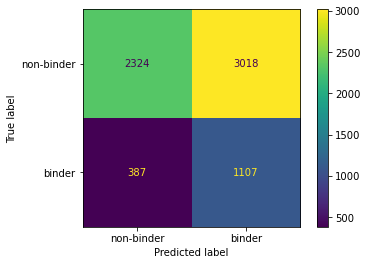

In [72]:
idx = 11
print(model_names[idx], paths[idx])
save_dir = next(Path(out_dir / f"{paths[idx]}").glob("*"))
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
plot_confusion_matrix(pred_paths, threshold, normalize=None)


In [36]:
t = ["/home/sebastian/masters/data/results_2/lstm_esm_ps_nested_loo/b3edafc0112356cefbdde3ca0ec5b396/pred_0.pt",
    "/home/sebastian/masters/data/results_2/lstm_esm_ps_nested_loo/b3edafc0112356cefbdde3ca0ec5b396/pred_1.pt"]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(t, threshold)

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


### 5 fold CV

In [29]:
overall_CV_results_df = pd.DataFrame(columns=[
    "Model", 
    "AUC",
    f"MCC (threshold = {threshold})",
])

model_names = [
    #"Single LSTM PS",
    #"Single LSTM PS (swapped negatives)",
    "Single LSTM BLOSUM50 (no swapped negatives)",
    "Single LSTM PS (no swapped negatives)",
    "Single LSTM PS (FoldX) (no swapped negatives)",
    "Single LSTM energy terms",
    "Quad LSTM BLOSUM50",
    "Quad LSTM BLOSUM50 (no swapped negatives)",
    "Quad LSTM PS",
    "Quad LSTM PS (no swapped negatives)",
    "Quad LSTM PS+ESM",
    "Quad LSTM PS+ESM (no swapped negatives)",
    "Quad LSTM ESM",
    "Quad LSTM ESM (no swapped negatives)",
    "Quad LSTM PS (FoldX)",
    "Quad LSTM PS (FoldX) (no swapped negatives)",
    "Quad LSTM PS+ESM (FoldX)",
    "Quad LSTM PS+ESM (FoldX) (no swapped negatives)",
    "Quad LSTM PS (Rosetta)",
    "Quad LSTM PS (Rosetta) (no swapped negatives)",
    "Quad LSTM PS+ESM (Rosetta)",
    "Quad LSTM PS+ESM (Rosetta) (no swapped negatives)",
    #"CDR3+peptide LSTM PS",
    #"CDR3+peptide LSTM PS (swapped negatives)",
    "Modified ProteinSolver",
    "Modified ProteinSolver (no swapped negatives)",
    "Quad LSTM PS low coverage"
    #"Modified ProteinSolver (FoldX)",
    #"Modified ProteinSolver (Rosetta)"
    
    
]

paths = [
    #"lstm_ps_single",
    #"lstm_ps_single_swapped",
    "lstm_single_blosum_80_cv_no_swapped", # this is low cov
    "lstm_single_ps_80_cv_no_swapped",  # this is low cov
    "lstm_single_ps_foldx_80_cv_no_swapped", # this is low cov
    "lstm_single_energy_80_cv",
    "lstm_blosum_80_cv",
    "lstm_blosum_80_cv_no_swapped",
    "lstm_ps_80_cv",
    "lstm_ps_80_no_swapped",
    "lstm_esm_ps_80_cv",
    "lstm_esm_ps_80_cv_no_swapped",
    "lstm_esm_80_cv",
    "lstm_esm_80_cv_no_swapped",
    "lstm_ps_foldx_80_cv",
    "lstm_ps_foldx_80_cv_no_swapped",
    "lstm_esm_ps_foldx_80_cv",
    "lstm_esm_ps_foldx_80_cv_no_swapped",
    "lstm_ps_rosetta_80_cv",
    "lstm_ps_rosetta_80_cv_no_swapped",
    "lstm_esm_ps_rosetta_80_cv",
    "lstm_esm_ps_rosetta_80_cv_no_swapped",
    #"lstm_ps_cdr_pep_only",
    #"lstm_ps_cdr_pep_only_swapped",
    "proteinsolver_finetune_80_cv",
    "proteinsolver_finetune_80_cv_no_swapped",
    "lstm_ps_80_cv_cluster_cdr3b_low_cov",
    #"proteinsolver_finetune_foldx",
    #"proteinsolver_finetune_rosetta"
    
]
for model_name, path in zip(model_names, paths):
    print(model_name, path)
    try:
        save_dir = next(Path(out_dir / f"{path}").glob("*"))
        pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold-3)]
        overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
        overall_row = [model_name, overall_auc, overall_mcc]
        overall_CV_results_df = overall_CV_results_df.append(
            pd.Series(overall_row, index=overall_CV_results_df.columns), ignore_index=True
        )
    except:
        print(model_name, "failed!")

Single LSTM BLOSUM50 (no swapped negatives) lstm_single_blosum_80_cv_no_swapped
Single LSTM PS (no swapped negatives) lstm_single_ps_80_cv_no_swapped
Single LSTM PS (FoldX) (no swapped negatives) lstm_single_ps_foldx_80_cv_no_swapped
Single LSTM energy terms lstm_single_energy_80_cv
Quad LSTM BLOSUM50 lstm_blosum_80_cv
Quad LSTM BLOSUM50 (no swapped negatives) lstm_blosum_80_cv_no_swapped
Quad LSTM PS lstm_ps_80_cv
Quad LSTM PS (no swapped negatives) lstm_ps_80_no_swapped
Quad LSTM PS (no swapped negatives) failed!
Quad LSTM PS+ESM lstm_esm_ps_80_cv
Quad LSTM PS+ESM (no swapped negatives) lstm_esm_ps_80_cv_no_swapped
Quad LSTM ESM lstm_esm_80_cv
Quad LSTM ESM (no swapped negatives) lstm_esm_80_cv_no_swapped
Quad LSTM PS (FoldX) lstm_ps_foldx_80_cv
Quad LSTM PS (FoldX) failed!
Quad LSTM PS (FoldX) (no swapped negatives) lstm_ps_foldx_80_cv_no_swapped
Quad LSTM PS (FoldX) (no swapped negatives) failed!
Quad LSTM PS+ESM (FoldX) lstm_esm_ps_foldx_80_cv
Quad LSTM PS+ESM (FoldX) failed!
Quad

In [30]:
overall_CV_results_df

,Model,AUC,MCC (threshold = 0.15)
0,Single LSTM BLOSUM50 (no swapped negatives),0.790616,0.472572
1,Single LSTM PS (no swapped negatives),0.790597,0.379914
2,Single LSTM PS (FoldX) (no swapped negatives),0.782977,0.370908
3,Single LSTM energy terms,0.691721,0.210768
4,Quad LSTM BLOSUM50,0.895647,0.623608
5,Quad LSTM BLOSUM50 (no swapped negatives),0.896549,0.587877
6,Quad LSTM PS,0.890501,0.610589
7,Quad LSTM PS+ESM,0.894009,0.594833
8,Quad LSTM PS+ESM (no swapped negatives),0.898725,0.571183
9,Quad LSTM ESM,0.897504,0.597468


In [ ]:
# do high coverage mmseq and check number of clusters

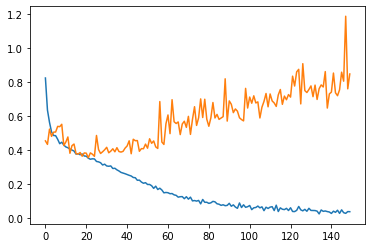

In [14]:
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_2/lstm_single_ps_80_cv_no_swapped/e789355eb2bdca5f475af91d0cadc5a5/")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(loss_paths[3])
plt.plot(t["train"])
plt.plot(t["valid"])

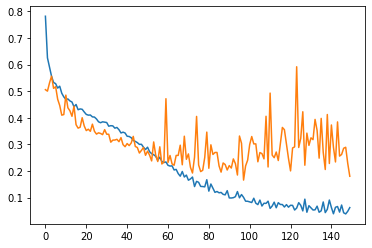

In [135]:
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_2/lstm_ps_single_foldx_no_swapped/bc38a2d1a44520efe7c92ab701554875//")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(loss_paths[3])
plt.plot(t["train"])
plt.plot(t["valid"])

In [17]:
t = 5e-5

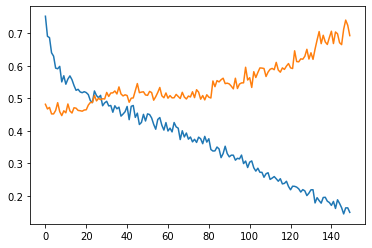

In [37]:
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_2/lstm_ps_foldx_no_swapped/1a74acd389cb2982398cf6aa68b84998")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(loss_paths[13])
plt.plot(t["train"])
plt.plot(t["valid"])

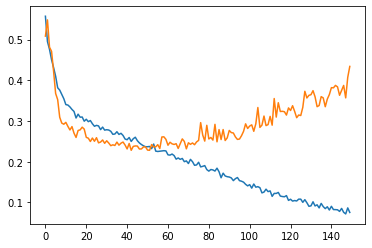

In [24]:
#save_dir = Path(out_dir / f"{path}/b3edafc0112356cefbdde3ca0ec5b396")
save_dir = Path("/home/sebastian/masters/data/results_2/lstm_ps_80_cv_cluster_cdr3b_low_cov/b3edafc0112356cefbdde3ca0ec5b396")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(cv_fold)]
t = torch.load(loss_paths[1])
plt.plot(t["train"])
plt.plot(t["valid"])